
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch: 1, Discriminator Loss:  0.2132, Generator Loss:  0.0643
Epoch: 2, Discriminator Loss:  0.2285, Generator Loss:  0.0194
Epoch: 3, Discriminator Loss:  0.2364, Generator Loss:  0.0126
Epoch: 4, Discriminator Loss:  0.2385, Generator Loss:  0.0250
Epoch: 5, Discriminator Loss:  0.2307, Generator Loss:  0.0188
Epoch: 6, Discriminator Loss:  0.2371, Generator Loss:  0.0063
Epoch: 7, Discriminator Loss:  0.2528, Generator Loss:  0.0125
Epoch: 8, Discriminator Loss:  0.2186, Generator Loss:  0.0063
Epoch: 9, Discriminator Loss:  0.2312, Generator Loss:  0.0250
Epoch: 10,

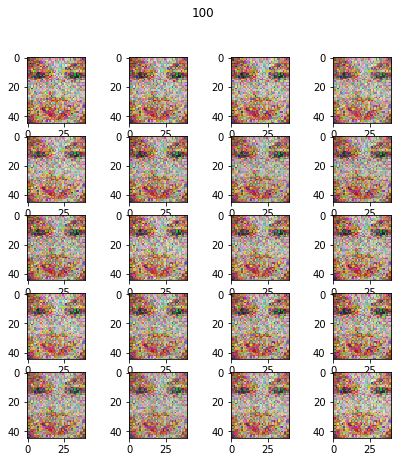

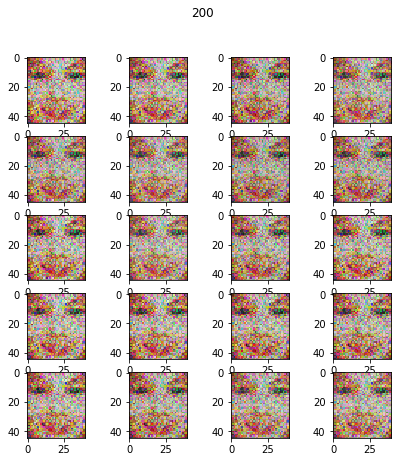

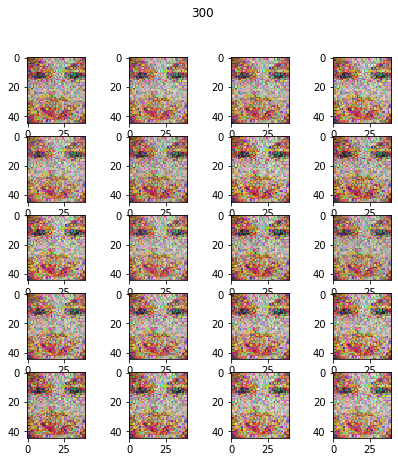

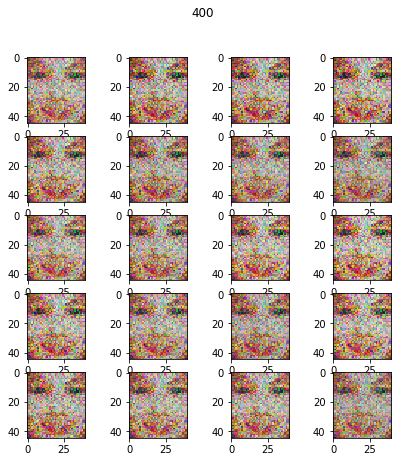

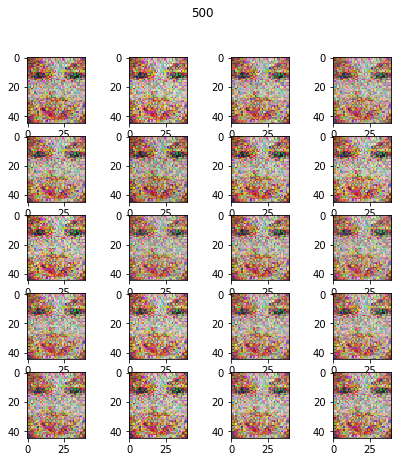

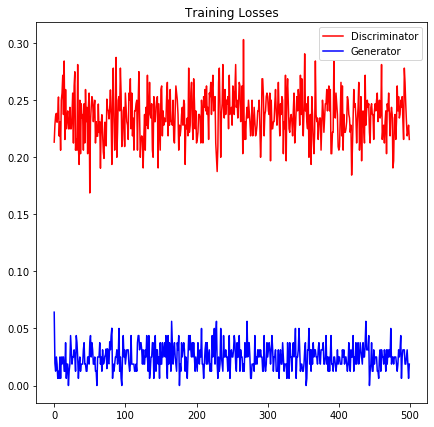

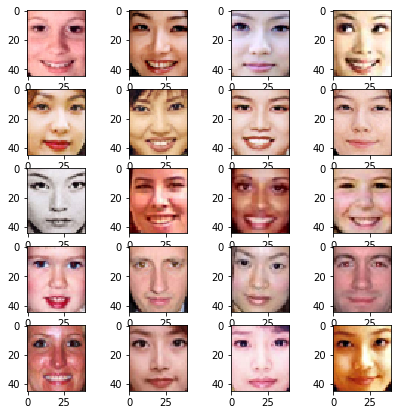

In [1]:
# 필요한 라이브러리 불러들임 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image as Im
import glob   
import os
%matplotlib inline

# 그래프 리셋
tf.reset_default_graph() 
# 재현성위한 시드 설정
tf.set_random_seed(1)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------
files=glob.glob('./face20/*.png')
img=[]        
for file in files:
    temp=Im.open(file)
    temp=np.array(temp)
    temp=temp[:,:,0:3]/255. # RGBA에서 투명도를 나타내는  a(alpha) 를 삭제하여 RGB로
    img.append(temp)        

# 리스트를 array로
x=np.asarray(img)
n_cell=np.prod(x.shape[1:4]) # 45*40*3=5400
# 이미지를 벡터로 =[20,5400]
X_vec=np.reshape(x,[len(img),n_cell])

# 관측치 수
sample_size=X_vec.shape[0] #=20
# 입력 변수 수
input_dim = X_vec.shape[1] #=5400


#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 입력 잡음신호의 차원: 100
# 생성자의 두 은닉층 크기: 128
# 판별자의 두 은닉층 크기: 128
# 미니배치 크기: 20
# 반복 수: 500
# 학습률 : 0.001
learning_rate = 0.001
batch_size = 20
z_size = 100
nepochs = 500  
g_hidden_size = 128 # 생성자 은닉층 크기
d_hidden_size = 128 # 판별자  은닉층 크기

# 드롭아웃에서 보존할 노드의 비율
keep_prob = tf.placeholder(tf.float32,name='keep_prob')

# 진짜데이터 placeholder
X = tf.placeholder(tf.float32, shape=[None, input_dim], name='X')
# 잡음 placeholder
Z = tf.placeholder(tf.float32, shape=[None, z_size], name='Z')

# 생성망의 가중치와 편의 정의(# 사비에르 초기치 사용)
G_W1 = tf.get_variable('G_W1',shape=[z_size,g_hidden_size],initializer=tf.contrib.layers.xavier_initializer())
G_b1 = tf.Variable(tf.zeros(shape=[g_hidden_size]), name='G_b1')
G_W2 = tf.get_variable('G_W2',shape=[g_hidden_size,input_dim],initializer=tf.contrib.layers.xavier_initializer())
G_b2 = tf.Variable(tf.zeros(shape=[input_dim]), name='G_b2')
theta_G = [G_W1, G_W2, G_b1, G_b2]

# 판별망의 가중치와 편의 정의(# 사비에르 초기치 사용)
D_W1 = tf.get_variable('D_W1',shape=[input_dim,d_hidden_size],initializer=tf.contrib.layers.xavier_initializer())
D_b1 = tf.Variable(tf.random_normal([d_hidden_size]), name='D_b1')
D_W2 = tf.get_variable('D_W2',shape=[d_hidden_size,1],initializer=tf.contrib.layers.xavier_initializer())
D_b2 = tf.Variable(tf.random_normal([1]), name='D_b2')
theta_D = [D_W1, D_W2, D_b1, D_b2]

#------------------------------------------------
# 생성자 정의: 입력된 진짜 데이터와 유사한 가짜 데이터 생성
#------------------------------------------------
def generator(z):
        h1 = tf.matmul(z, G_W1) + G_b1        
        h1 = tf.maximum(0., h1)  #ReLU
        h2 = tf.matmul(h1, G_W2) + G_b2
        out = tf.nn.tanh(h2) 
        return out

#------------------------------------------------
# 판별자 정의: 입력된 진짜 데이터와 가짜 데이터를 정확하게 분류
#------------------------------------------------
def discriminator(x):
        h1=tf.matmul(x, D_W1) + D_b1        
        h1 = tf.maximum(0., h1)  #ReLU  
        h1=tf.nn.dropout(h1, keep_prob)
        h2 = tf.matmul(h1, D_W2) + D_b2
        h2=tf.nn.dropout(h2, keep_prob)
        prob = tf.nn.sigmoid(h2)
        return prob, h2

G = generator(Z) # 가짜데이터
# 진짜 데이터의 판별망 결과 
D_real, D_logit_real = discriminator(X) 
# 가짜 데이터의 판별망 결과 
D_fake, D_logit_fake = discriminator(G)

# 비용함수 
# 판별자는 진짜데이터는 1, 가짜데이터는 0이 되게 
D_loss = 0.5 * (tf.reduce_mean((D_real - 1)**2) + 0.5*tf.reduce_mean(D_fake**2))
# 생성자는 가짜데이터의 판별망 결과가 1이 되게 만들어야 한다 
G_loss = 0.5 * tf.reduce_mean((D_fake - 1)**2)

# 판별망을 훈련할 때는  theta_D 만 업데이트 된다.
D_solver = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=theta_D)
# 생성망 훈련할 때는  theta_G 만 업데이트 된다.
G_solver = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=theta_G)

#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
sess=tf.Session(); 
sess.run(tf.global_variables_initializer())
losses = []

for epoch in range(nepochs):
    n_batch=int(sample_size/batch_size)
    
    for ii in range(n_batch):
        if ii!=n_batch:
              batch_images=X_vec[ii*batch_size:(ii+1)*batch_size]
        else:
              batch_images=X_vec[(ii+1)*batch_size:]           
        batch_images = batch_images*2 - 1   
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size)) 
        D_loss_curr,_ =sess.run([D_loss,D_solver], feed_dict={X: batch_images, Z: batch_z,keep_prob:0.8})
        G_loss_curr,_=sess.run([G_loss,G_solver], feed_dict={X: batch_images, Z: batch_z,keep_prob:0.8})               
        losss=D_loss_curr+G_loss_curr
        
    print('Epoch: {0}, Discriminator Loss: {1:7.4f}, Generator Loss: {2:7.4f}'  .format(epoch+1,D_loss_curr, G_loss_curr))
    losses.append((D_loss_curr, G_loss_curr))    
    # 100 에폭 마다 가짜데이터 그림    
    if (epoch+1)%100==0:
        tf.set_random_seed(0)
        sample_z = np.random.uniform(-1, 1, size=(20,z_size))
        gen_samples = sess.run(G,feed_dict={Z: sample_z})
        f,axes =plt.subplots(figsize=(7,7), nrows=5, ncols=4, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        for ii in range(20):
            plt.subplot(5,4,ii+1)
            gs=gen_samples[ii].reshape(45,40,3); 
            gs=(gs-np.min(gs))/(np.max(gs)-np.min(gs))
            plt.imshow(gs)

# 판별자, 생성자의 비용함수 그림 
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], 'r-',label='Discriminator')
plt.plot(losses.T[1], 'b-',label='Generator')

plt.title("Training Losses")
plt.legend()


#진짜 이미지 그림
f,axes =plt.subplots(figsize=(7,7), nrows=5, ncols=4, sharey=True, sharex=True)
for ii in range(20):
    plt.subplot(5,4,ii+1)
    gs=X_vec[ii].reshape(45,40,3);  gs=(gs-np.min(gs))/(np.max(gs)-np.min(gs))
    plt.imshow(gs)